# QTM347 Group Project
Team members: Max Cao, Zoe Ji, Kristen Li, Bowen You

In [1]:
pip install tensorflow


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /usr/local/Cellar/jupyterlab/4.0.6/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [36]:
pip install scipy


[notice] A new release of pip is available: 23.2.1 -> 23.3.1
[notice] To update, run: /usr/local/Cellar/jupyterlab/4.0.6/libexec/bin/python -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

2023-12-12 23:08:49.345462: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [9]:
# Imports
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [10]:
import scipy.stats as stats

In [11]:
# Load Inputs
df = pd.read_csv('/Users/apple/Desktop/google_trends_5yrs.csv',index_col=0)

In [12]:
df.head()

,economics,debt,inflation,metals,sell,bonds,risk,car,leverage,color,...,fun,short selling,earnings,holiday,profit,kitchen,train,ring,conflict,VIX
date,,,,,,,,,,,,,,,,,,,,,
12/9/2018,26,27,12,12,70,2,0,82,0,28,...,14,0,1,25,3,20,49,22,2,21.629999
12/16/2018,20,23,9,10,73,2,0,76,0,26,...,14,0,1,27,2,20,50,20,1,30.110001
12/23/2018,14,18,7,6,74,1,3,81,0,24,...,14,0,1,40,2,20,53,21,1,28.340000
12/30/2018,17,28,8,8,81,2,0,85,0,25,...,14,0,1,27,2,22,50,23,1,21.379999
1/6/2019,24,30,9,10,77,2,0,87,0,26,...,15,0,1,19,3,20,47,20,2,18.190001


In [13]:
features = df.iloc[:, :-1].values
vix = df.iloc[:, -1].values

scaler = MinMaxScaler()
features_scaled = scaler.fit_transform(features)

In [14]:
sequence_length = 6
X, y = [], []

for i in range(len(features_scaled) - sequence_length):
    X.append(np.concatenate((features_scaled[i:i + sequence_length, :], vix[i:i + sequence_length].reshape(-1, 1)), axis=1))
    y.append(vix[i + sequence_length])
    
X, y = np.array(X), np.array(y)

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [16]:
print("Shapes:")
print("(batch_size, time_steps, seq_len)")
print(f'X_train: {X_train.shape}')
print(f'y_train: {y_train.shape}')
print(f'X_test: {X_test.shape}')
print(f'y_test: {y_test.shape}')

Shapes:
(batch_size, time_steps, seq_len)
X_train: (203, 6, 99)
y_train: (203,)
X_test: (51, 6, 99)
y_test: (51,)


## PLS

In [17]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.cross_decomposition import PLSRegression
import sklearn.model_selection as skm
import sklearn.linear_model as skl

In [18]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
print("New shape of X_train after flattening:", X_train_flat.shape)

X_test_flat = X_test.reshape(X_test.shape[0], -1)
print("New shape of X_test after flattening:", X_test_flat.shape)

New shape of X_train after flattening: (203, 594)
New shape of X_test after flattening: (51, 594)


In [19]:
X_train_scaled = scaler.fit_transform(X_train_flat)
X_test_scaled = scaler.transform(X_test_flat)

In [20]:
K=5
kfold = skm.KFold(K, random_state=0, shuffle=True)

In [21]:
pls = PLSRegression(n_components=10, 
                   scale=True)
pls.fit(X_train_scaled, y_train)

PLSRegression(n_components=10)

In [22]:
param_grid = {'n_components':range(1, 17)} 
grid = skm.GridSearchCV(pls,
                        param_grid,
                        cv=kfold, scoring='neg_mean_squared_error')
grid.fit(X_train_scaled, y_train)
grid.best_params_

{'n_components': 7}

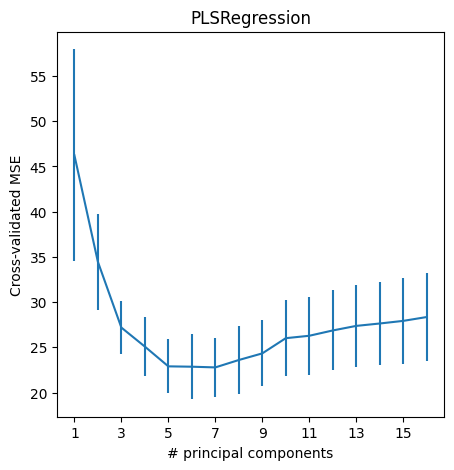

In [23]:
pls_fig, ax = subplots(figsize=(5,5)) 
n_comp = param_grid['n_components'] 
ax.errorbar(n_comp,
            -grid.cv_results_['mean_test_score'],
            grid.cv_results_['std_test_score'] / np.sqrt(K)) 
ax.set_ylabel('Cross-validated MSE', fontsize=10) 
ax.set_xlabel('# principal components', fontsize=10) 
ax.set_xticks(n_comp[::2])
plt.title('PLSRegression')
plt.show()

In [24]:
pls = PLSRegression(n_components=grid.best_params_['n_components'],
                   scale=True)
pls.fit(X_train_scaled, y_train)

PLSRegression(n_components=7)

In [25]:
train_pred = pls.predict(X_train_scaled)
np.mean((train_pred - y_train)**2)

4.120098908039277

In [26]:
test_pred = pls.predict(X_test_scaled)
test_mse = np.mean((test_pred - y_test)**2)
print(f'Test MSE for PLS Model: {test_mse}')

Test MSE for PLS Model: 28.87638244546841


In [30]:
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    # Avoid division by zero error
    y_true = np.where(y_true == 0, np.finfo(float).eps, y_true)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [31]:
test_mape = mape(y_test, test_pred)
print(f'Test MAPE for PLS Model: {test_mape}%')

Test MAPE for PLS Model: 27.918271292746038%


## Least Squared Linear Model

In [33]:
import statsmodels.api as sm 

In [34]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
print("New shape of X_train after flattening:", X_train_flat.shape)

X_test_flat = X_test.reshape(X_test.shape[0], -1)
print("New shape of X_test after flattening:", X_test_flat.shape)

New shape of X_train after flattening: (203, 594)
New shape of X_test after flattening: (51, 594)


In [35]:
model = sm.OLS(y_train, X_train_flat)
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                    nan
Method:                 Least Squares   F-statistic:                       nan
Date:                Tue, 12 Dec 2023   Prob (F-statistic):                nan
Time:                        23:10:12   Log-Likelihood:                 5722.4
No. Observations:                 203   AIC:                        -1.104e+04
Df Residuals:                       0   BIC:                        -1.037e+04
Df Model:                         202                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             0.2774        inf          0        nan         nan         nan
x2             0.2657        inf          0        nan         nan         nan
x3            -1.0564        inf         -0        nan         nan         nan
x4            -0.3711        inf         -0        nan         nan         nan
x5             1.1421        inf          0        nan         nan         nan
x6             3.1114        inf          0        nan         nan         nan
x7            -1.1374        inf         -0        nan         nan         nan
x8            -0.8605        inf         -0        nan         nan         nan
x9             1.6691        inf          0        nan         nan         nan
x10           -1.5596        inf         -0        nan         nan         nan
x11           -0.2262        inf         -0        nan         nan         nan
x12            0.3875        inf          0        nan         nan         nan
x13           -0.8589        inf         -0        nan         nan         nan
x14            0.6467        inf          0        nan         nan         nan
x15           -0.7355        inf         -0        nan         nan         nan
x16           -0.6061        inf         -0        nan         nan         nan
x17           -2.6624        inf         -0        nan         nan         nan
x18           -0.4126        inf         -0        nan         nan         nan
x19            2.3765        inf          0        nan         nan         nan
x20           -0.8960        inf         -0        nan         nan         nan
x21           -1.1294        inf         -0        nan         nan         nan
x22            0.4556        inf          0        nan         nan         nan
x23            1.1026        inf          0        nan         nan         nan
x24            1.2426        inf          0        nan         nan         nan
x25           -0.2873        inf         -0        nan         nan         nan
x26           -1.1497        inf         -0        nan         nan         nan
x27           -0.4544        inf         -0        nan         nan         nan
x28           -0.2434        inf         -0        nan         nan         nan
x29            1.0195        inf          0        nan         nan         nan
x30           -0.7384        inf         -0        nan         nan         nan
x31            1.2052        inf          0        nan         nan         nan
x32           -0.7892        inf         -0        nan         nan         nan
x33            0.7707        inf          0        nan         nan         nan
x34           -0.6422        inf         -0        nan         nan         nan
x35           -0.4698        inf         -0        nan         nan         nan
x36            0.7982        inf          0        nan         nan         nan
x3

In [36]:
test_pred = results.predict(X_test_flat)
test_mse = np.mean((y_test - test_pred)**2)
print(f'Test MSE for Least Square Model: {test_mse}')

Test MSE for Least Square Model: 27.341832653325724


In [37]:
test_mape = mape(y_test, test_pred)
print(f'Test MAPE for OLS Model: {test_mape}%')

Test MAPE for OLS Model: 24.0132852493724%


## Ridge Regression

In [38]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [39]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
print("New shape of X_train after flattening:", X_train_flat.shape)

X_test_flat = X_test.reshape(X_test.shape[0], -1)
print("New shape of X_test after flattening:", X_test_flat.shape)

New shape of X_train after flattening: (203, 594)
New shape of X_test after flattening: (51, 594)


In [40]:
lambdas = 10**np.linspace(4, -6, 100) / y_train.std()

ridgeCV = skl.ElasticNetCV(alphas=lambdas, 
                           l1_ratio=0, 
                           cv=kfold)
scaler = StandardScaler(with_mean=True, with_std=True)
pipeCV = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])
pipeCV.fit(X_train_flat, y_train)
tuned_ridge = pipeCV.named_steps['ridge']
tuned_ridge.alpha_

0.6878204112627732

Text(0.5, 1.0, 'RidgeRegression')

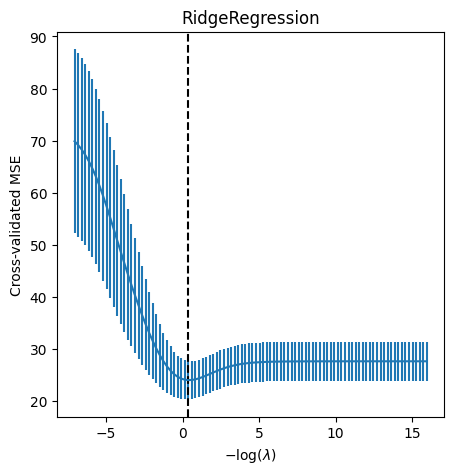

In [41]:
ridgeCV_fig, ax = subplots(figsize=(5,5))
ax.errorbar(-np.log(tuned_ridge.alphas_), tuned_ridge.mse_path_.mean(1),
            yerr=tuned_ridge.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_ridge.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=10)
ax.set_ylabel('Cross-validated MSE', fontsize=10);
plt.title('RidgeRegression')

In [42]:
tuned_ridge.coef_

array([ 4.17250204e-02,  8.12019134e-02, -3.44211959e-02, -1.02745939e-01,
        7.44250455e-02,  2.94665732e-01,  1.50318991e-02, -1.11169452e-01,
        2.15940849e-01,  4.65089659e-02, -1.73405221e-01,  4.45535106e-02,
        3.99243466e-02,  2.57350288e-02, -3.83571991e-03, -1.03339094e-01,
       -4.44739717e-02, -2.20401844e-02,  2.01430157e-01, -5.72169739e-02,
       -1.92490239e-02,  4.56182060e-02,  1.72007585e-01,  8.54055317e-02,
        7.42272204e-02, -2.09128847e-01, -5.37715502e-02,  1.08457579e-01,
        1.68420247e-01,  2.09679400e-02,  1.26515488e-01, -8.57756037e-02,
        9.39740816e-02, -5.11283413e-02,  9.71086552e-02,  7.19358200e-02,
        4.51221485e-04, -3.39989566e-01, -6.24756577e-03, -1.98206014e-01,
        4.94993757e-02, -5.55415776e-02, -1.13972840e-02, -2.13713163e-01,
        1.33715859e-01,  6.60639901e-02, -4.50831112e-02, -2.33793422e-02,
        1.14358298e-02, -8.85622385e-02,  3.03796994e-02, -5.06902619e-02,
        3.42797586e-02,  

In [43]:
ridge = skl.ElasticNet(alpha=tuned_ridge.alpha_, l1_ratio=0)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('ridge', ridge)]) 
pipe.fit(X_train_flat, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('ridge', ElasticNet(alpha=0.6878204112627732, l1_ratio=0))])

In [44]:
test_pred = pipe.predict(X_test_flat)
test_mse = np.mean((test_pred - y_test)**2)
print(f'Test MSE for Ridge Regression Model: {test_mse}')

Test MSE for Ridge Regression Model: 26.14637086423418


In [45]:
test_mape = mape(y_test, test_pred)
print(f'Test MAPE for Ridge Regression Model: {test_mape}%')

Test MAPE for Ridge Regression Model: 27.72629953324128%


## Lasso 

In [46]:
X_train_flat = X_train.reshape(X_train.shape[0], -1)
print("New shape of X_train after flattening:", X_train_flat.shape)

X_test_flat = X_test.reshape(X_test.shape[0], -1)
print("New shape of X_test after flattening:", X_test_flat.shape)

New shape of X_train after flattening: (203, 594)
New shape of X_test after flattening: (51, 594)


In [47]:
lassoCV = skl.ElasticNetCV(n_alphas=100, 
                           l1_ratio=1, 
                           cv=kfold)
pipeCV = Pipeline(steps=[('scaler', scaler), ('lasso', lassoCV)])
pipeCV.fit(X_train_flat, y_train)
tuned_lasso = pipeCV.named_steps['lasso']
tuned_lasso.alpha_

0.4948883340225191

In [48]:
print(tuned_lasso.coef_)

[-0.          0.          0.          0.         -0.          0.13830748
  0.         -0.          0.          0.         -0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.         -0.         -0.          0.          0.          0.
  0.          0.          0.          0.          0.         -0.
  0.         -0.          0.         -0.         -0.          0.
  0.         -0.          0.          0.         -0.         -0.
 -0.          0.          0.         -0.          0.          0.
  0.          0.          0.         -0.          0.          0.
  0.         -0.          0.55350711  0.          0.         -0.
  0.         -0.          0.          0.          0.          0.
  0.          0.          0.          0.         -0.          0.
  0.         -0.          0.         -0.          0.          0.
  0.          0.          0.         -0.          0.          0.
 -0.          0. 

Text(0.5, 1.0, 'LassoRegression')

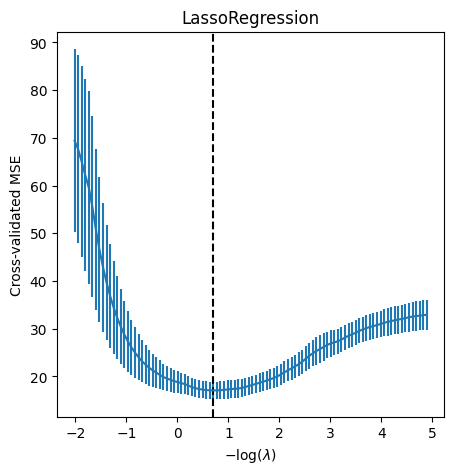

In [49]:
lassoCV_fig, ax = subplots(figsize=(5,5))
ax.errorbar(-np.log(tuned_lasso.alphas_),
tuned_lasso.mse_path_.mean(1),
yerr=tuned_lasso.mse_path_.std(1) / np.sqrt(K))
ax.axvline(-np.log(tuned_lasso.alpha_), c='k', ls='--')
ax.set_xlabel('$-\log(\lambda)$', fontsize=10)
ax.set_ylabel('Cross-validated MSE', fontsize=10);
plt.title('LassoRegression')

In [50]:
lasso = skl.ElasticNet(alpha=tuned_lasso.alpha_, l1_ratio=1)
scaler = StandardScaler(with_mean=True, with_std=True)
pipe = Pipeline(steps=[('scaler', scaler), ('lasso', lasso)]) 
pipe.fit(X_train_flat, y_train)

Pipeline(steps=[('scaler', StandardScaler()),
                ('lasso', ElasticNet(alpha=0.4948883340225191, l1_ratio=1))])

In [51]:
test_pred = pipe.predict(X_test_flat)
test_mse = np.mean((test_pred - y_test)**2)
print(f'Test MSE for Lasso Regression Model: {test_mse}')

Test MSE for Lasso Regression Model: 10.30812601485335


In [52]:
test_mape = mape(y_test, test_pred)
print(f'Test MAPE for Lasso Regression Model: {test_mape}%')

Test MAPE for Lasso Regression Model: 15.961538861972944%
